In [1]:
!wget http://www.atarimania.com/roms/Roms.rar
!unrar e Roms.rar
!unzip ROMS.zip
!python -m atari_py.import_roms /content/ROMS

--2021-06-23 15:08:31--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  10.61M  4.73MB/s    in 2.2s    

2021-06-23 15:08:34 (4.73 MB/s) - ‘Roms.rar.1’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar


Would you like to replace the existing file HC ROMS.zip
11826711 bytes, modified on 2019-12-22 11:24
with a new one
11826711 bytes, modified on 2019-12-22 11:24

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Y

Extracting  HC ROMS.zip                                                   36%  OK 

Would you like to replace the existing file ROMS.zip
8181588 bytes, modified on 2019-12-22 11:23
wi

In [2]:
!pip install baselines

  Using cached https://files.pythonhosted.org/packages/cf/8c/64e0630b3d450244feef0688d90eab2448631e40ba6bdbd90a70b84898e7/mujoco-py-1.50.1.68.tar.gz
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ujp42hy9/mujoco-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ujp42hy9/mujoco-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-uvf05h2t/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [52]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from collections import deque, Counter
import random
from datetime import datetime
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

6
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


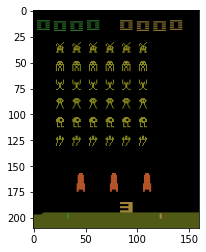

In [53]:
env = gym.make("SpaceInvaders-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())
observation = env.reset()
print(observation.shape)
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()
    observation, _, _, _ = env.step(1)

In [54]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.8  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

[42, 742738649]

In [55]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84,4 ))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(n_outputs, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

In [56]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

while True:  # Run until solved
    state = np.array(env.reset())
  
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(n_outputs)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
     
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, n_outputs)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    running_reward = np.mean(episode_reward_history[-100:])

    episode_count += 1

    if episode_count > 100:  
        
        break

running reward: 3.57 at episode 42, frame count 10000
running reward: 3.49 at episode 87, frame count 20000


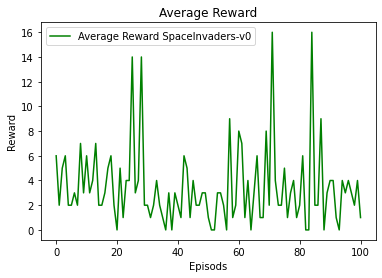

In [59]:
episods = range(episode_count)
plt.plot(episods, episode_reward_history, 'g', label='Average Reward SpaceInvaders-v0')

plt.title('Average Reward')
plt.xlabel('Episods')
plt.ylabel('Reward')
plt.legend()
plt.show()